In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.linalg import eigh
import random
from sklearn.metrics import silhouette_score as ss
from sklearn.metrics import adjusted_rand_score as ars
from sklearn.cluster import KMeans
from itertools import combinations as cb

In [32]:
random.seed(42)
rand_num = random.sample(range(0, 101), 25)
# rand_num = random.sample(range(100, 201), 25)
rand_num = sorted(rand_num)

In [33]:
rand_factor = []
rand_noise = []
for i in range(200):
    rand_factor.append(random.random())
    rand_noise.append(random.random()*0.1)

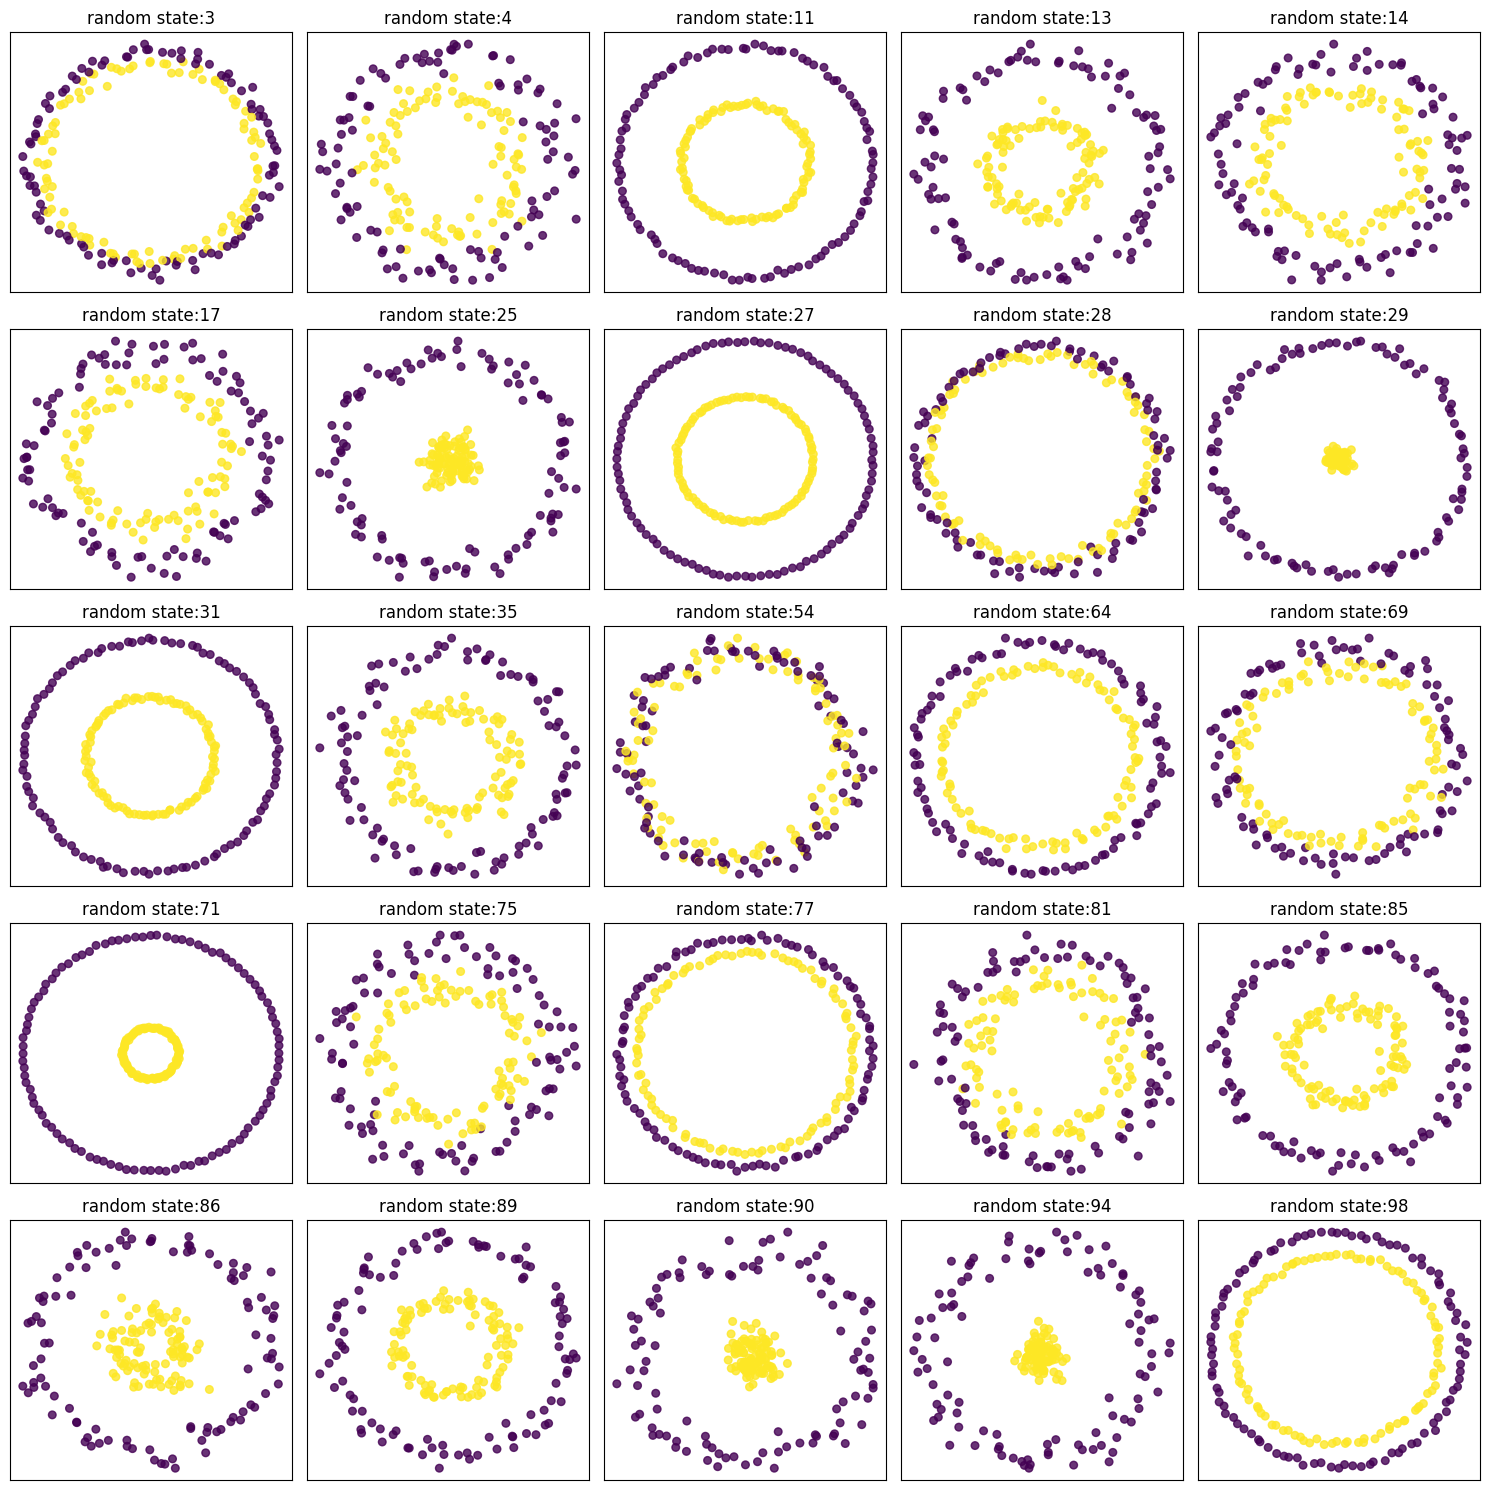

In [34]:
# def get_blobs(n_samples=200, centers=4, random_state=42):
#     X, Y = datasets.make_blobs(n_samples=n_samples, centers=centers, random_state=random_state)
#     plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=30, alpha=0.8)
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.show()
    
def get_blobs(n_samples=200, centers=4, random_state=42):
    # X, Y = datasets.make_blobs(n_samples=n_samples, centers=centers, random_state=random_state)
    n = random.randint(0, n_samples)
    X, Y = datasets.make_circles(n_samples=n_samples, factor=rand_factor[n], noise=rand_noise[n], random_state=random_state)
    return X, Y

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten() 
for i in range(25):
    seed = rand_num[i]
    X, Y = get_blobs(random_state=seed)
    ax = axes[i]
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=30, alpha=0.8)
    ax.set_title(f'random state:{seed}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [35]:
fig.savefig('rd_plots/original_circle_100.png')

In [36]:
def power_method(A, num_iter=200, tol=1e-6):
    n = A.shape[0]
    x = np.ones(n)

    for _ in range(num_iter):
        x = A @ x
        x_norm = np.linalg.norm(x)
        x_next = x / x_norm

        # stopping criterion
        if np.linalg.norm(x_next - x) < tol:
            break
        x = x_next

    eig_val = (x.T @ (A @ x)) / (x.T @ x)
    return eig_val, x

def deflate(A, eig_val, eig_vec):
    return A - eig_val * np.outer(eig_vec, eig_vec)
    
def core_routine(X, Y, num_clusters=2):
    # matrices
    A = np.exp(-pairwise_distances(X, metric='euclidean'))
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    L_inv = np.linalg.inv(L + np.eye(L.shape[0]) * 1e-6)
    L_inv_norm = L_inv / np.linalg.norm(L_inv)

    # power and deflation methods
    def_val = []
    def_vec = []
    def_mat = L_inv
    
    num_eig_pair = num_clusters # bear in mind that the first pair lacks the ability to group data
    
    for i in range(num_eig_pair):  
        eig_val, eig_vec = power_method(def_mat)
        def_val.append(eig_val)
        def_vec.append(eig_vec)
        def_mat = deflate(def_mat, eig_val, eig_vec)

    return def_vec

In [37]:
def le_visualization(def_vec, Y):
    fig, axs = plt.subplots(2, 3, figsize=(15, 5))
    axs = axs.flatten() 
    axs[0].scatter(np.zeros(len(def_vec[1])), def_vec[1], c=Y, cmap='viridis', s=30, alpha=0.8)
    axs[1].scatter(np.zeros(len(def_vec[2])), def_vec[2], c=Y, cmap='viridis', s=30, alpha=0.8)
    axs[2].scatter(np.zeros(len(def_vec[3])), def_vec[3], c=Y, cmap='viridis', s=30, alpha=0.8)
    axs[3].scatter(def_vec[1], def_vec[2], c=Y, cmap='viridis', s=30, alpha=0.8)
    axs[4].scatter(def_vec[1], def_vec[3], c=Y, cmap='viridis', s=30, alpha=0.8)
    axs[5].scatter(def_vec[2], def_vec[3], c=Y, cmap='viridis', s=30, alpha=0.8)
    plt.show()

In [38]:
def get_score(X, Y, method): # ss or ard
    km = KMeans(n_clusters=2, random_state=42).fit(X)
    label_predicted = km.fit_predict(X)
    if method=='ss':
        return ss(X, label_predicted)
    elif method=='ars':
        return ars(Y, label_predicted)

def get_best_le(def_vec, Y, method):
    elem = range(len(def_vec))
    all_cb = list(cb(elem,2))
    temp_score = []
    for pair in all_cb:
        temp_data = np.stack((def_vec[pair[0]], def_vec[pair[1]]), axis=1)
        temp_score.append(get_score(X=temp_data, Y=Y, method=method))
    best_idx = np.argmax(temp_score)
    return all_cb[best_idx], np.round(temp_score[best_idx],3)

def get_best_plot(rn, def_vec, Y, best_pair, best_score, method, ax):
    i = best_pair[0]
    j = best_pair[1]
    ax.scatter(def_vec[i], def_vec[j], c=Y, cmap='viridis', s=30, alpha=0.8)
    ax.set_title(f'rs {rn} with {method} score {best_score}')
    # ax.set_xlabel(f'featrue {i}')
    # ax.set_ylabel(f'featrue {j}')
    ax.set_xticks([])
    ax.set_yticks([])
    # fig.savefig(f'rd_plots/random_state_{rn}.png')
    # plt.show()

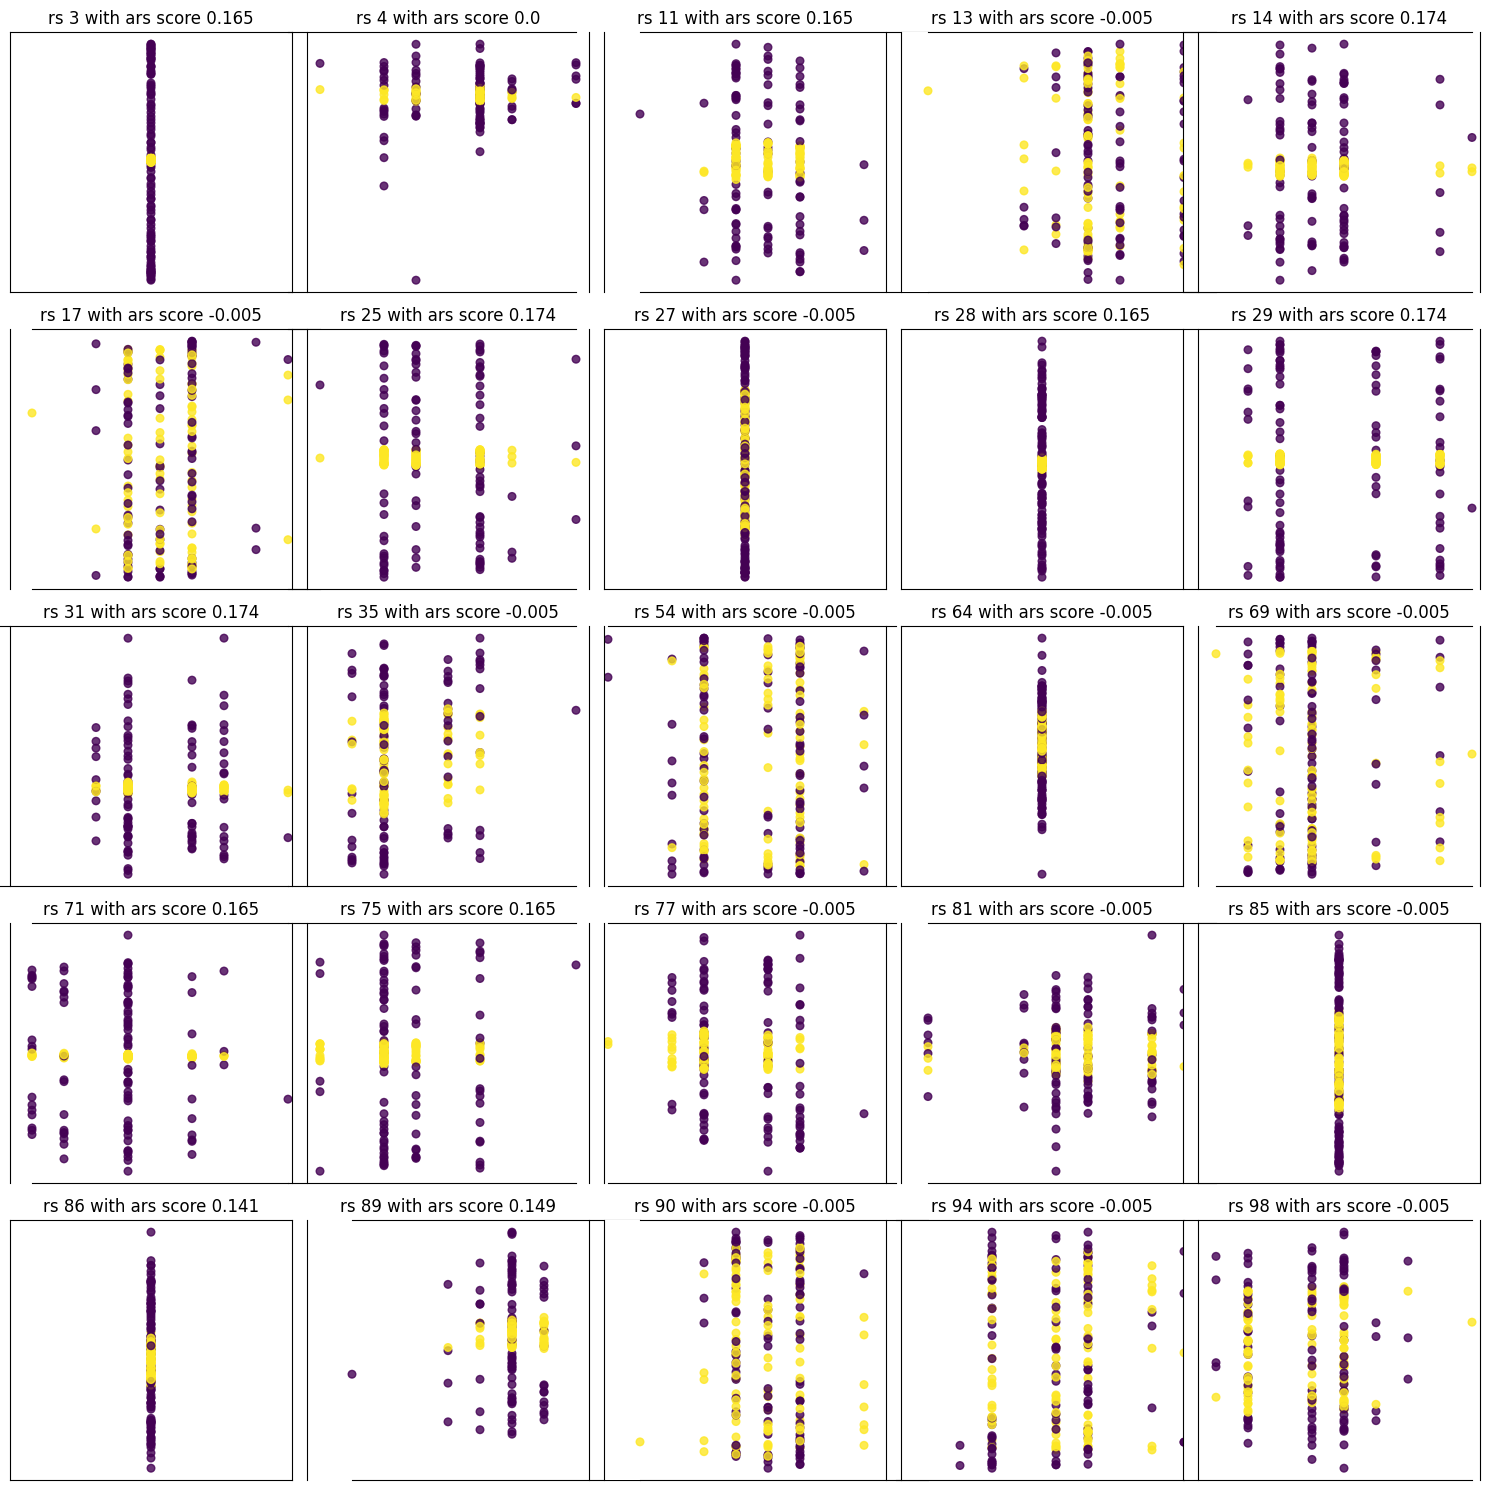

In [39]:
score_list = []

fig, axes = plt.subplots(5, 5, figsize=(15, 15))  # 5x5 grid, adjust size as needed
axes = axes.flatten() 

for i, rn in enumerate(rand_num):
    # generate dataset
    X, Y = get_blobs(random_state=rn)
    # core routine to embed data on LE
    def_vec = core_routine(X, Y)
    # get the best indices and corresponding score
    method = 'ars' # or ss
    best_pair, best_score = get_best_le(def_vec, Y, method)
    score_list.append(best_score)
    # plot
    get_best_plot(rn, def_vec, Y, best_pair, best_score, method, ax=axes[i])

plt.tight_layout()
plt.show()

In [40]:
fig.savefig('rd_plots/evaluation_le_circle_100.png')

In [41]:
score_df = pd.DataFrame([rand_num, score_list]).T
score_df.columns = ['random_state','score']
score_df['random_state'] = score_df['random_state'].astype('int')
score_df

,random_state,score
0,3,0.165
1,4,0.000
2,11,0.165
3,13,-0.005
4,14,0.174
5,17,-0.005
6,25,0.174
7,27,-0.005
8,28,0.165
9,29,0.174


In [42]:
score_df.to_csv('rd_plots/score_table_circle_100.csv', index=False)